<h1><center>Solving for Happiness - Machine Learning Model Tuning</center></h1>

In [26]:
# import libraries to be used throughout project
import pandas as pd
import numpy as np
import matplotlib 
import math
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings

In [27]:
front = '../data/'
back_other = '_other.csv'
back_test = '_test.csv'

# dictionary to hold scores of all models across lags 
score_dict = {}

In [28]:
# lists to grab right files from directory 
X = ['X1','X2','X3','X4','X5']
y = ['y1','y2','y3','y4','y5']

# lists to save all X_other, X_test, y_other, and y_test across all lags 
X_other_list = []
X_test_list = []
y_other_list = []
y_test_list = []

# save all lagged dataframes to list
for i in range(5):
    
    # import laged dataframe 
    X_other = pd.read_csv(front + X[i] + back_other)
    X_other.drop(['Unnamed: 0'],axis=1,inplace=True)

    X_test = pd.read_csv(front + X[i] + back_test)
    X_test.drop(['Unnamed: 0'],axis=1,inplace=True)

    y_other = pd.read_csv(front + y[i] + back_other)
    y_other.drop(['Unnamed: 0'],axis=1,inplace=True)

    y_test = pd.read_csv(front + y[i] + back_test)
    y_test.drop(['Unnamed: 0'],axis=1,inplace=True)

    # convert dataframes to series 
    y_test = y_test['Target Score']
    y_other = y_other['Target Score']

    X_other_list.append(X_other)
    X_test_list.append(X_test)
    y_other_list.append(y_other)
    y_test_list.append(y_test)
    

<h2>Baseline Regression Model</h2>

The below analysis examines the baseline RMSE metric for a constant regression model. This metric is calculated by predicting the average value of the target variable for each of the datapoints. This baseline will be used to judge each of the machine learning algorithms below. A 'good' model should produce a RMSE score that is at least lower than the baseline metric calculated here. 

In [29]:
# create true series for analysis
y_true = pd.concat([y_other,y_test])

# create mean series
pred_avg = y_true.mean()

avg_list = np.ones(len(y_true))*pred_avg
y_avg = pd.Series(avg_list)

# calculate the baseline RMSE metric
mse_base = mean_squared_error(y_true,y_avg)
rmse_base = math.sqrt(mse_base)
r2_base = r2_score(y_true,y_avg)

print('Baseline RMSE Score: {:.4}'.format(rmse_base))
print('Baseline R2 Score: {:.4}'.format(r2_base))

Baseline RMSE Score: 1.039
Baseline R2 Score: 0.0


<h2> General Machine Learning Algorithm </h2>

The below code creates a PredefinedSplit object, which will be used to maintain the data integrity of the train and validation sets during the GrindSearchCV training process.

In [30]:
# import predefinedsplit to maintain data integrity during cv
from sklearn.model_selection import PredefinedSplit

# all predefined splits 
all_ps = []

# indexes for the different train sets 
ti = [470,423,376,329,282]

# The indices which have zero or positive values, will be kept in validation during the grid split
val_indices = np.full((94,), 0, dtype=int)

for i in range(5):
    
    # The indices which have the value -1 will be kept in train during the grid split 
    train_indices = np.full((ti[i],), -1, dtype=int)

    test_fold = np.append(train_indices, val_indices)

    # create a predefinedsplit instance that has the indexes of the train and val sets 
    ps = PredefinedSplit(test_fold)
    
    all_ps.append(ps)

# Check how many splits will be done, based on test_fold
for i in range(5):
    print('Number of splits to be created by ps:',all_ps[i].get_n_splits())

# print the indexes of the train and validation sets 
# for train_index, test_index in ps.split():
#     print("TRAIN Datapoints:\n", train_index)
#     print("Validation Datapoints:\n", test_index)

Number of splits to be created by ps: 1
Number of splits to be created by ps: 1
Number of splits to be created by ps: 1
Number of splits to be created by ps: 1
Number of splits to be created by ps: 1


The below code creates a preprocessor, which will be passed to GrindSearchCV in order to preprocess the dataset before completing the training and validation of our machine learning algorithm.

In [31]:
# features for standardscaling preprocessing - lag1
num_ftrs1 = ['Target Year', 
            'Population lag 1 year', 'Population Current',
            'Life Ex lag 1 year','Life Ex Current', 
            'GDP lag 1 year', 'GDP Current', 
            'GDP_cap lag 1 year', 'GDP_cap Current',
            'CO2 lag 1 year', 'CO2 Current',
            'Happy lag 1 year']

# features for standardscaling preprocessing - lag2
num_ftrs2 = ['Target Year', 
            'Population lag 2 years', 'Population lag 1 year', 'Population Current',
            'Life Ex lag 2 years', 'Life Ex lag 1 year','Life Ex Current', 
            'GDP lag 2 years','GDP lag 1 year', 'GDP Current', 
            'GDP_cap lag 2 years', 'GDP_cap lag 1 year', 'GDP_cap Current',
            'CO2 lag 2 years', 'CO2 lag 1 year', 'CO2 Current',
            'Happy lag 2 years', 'Happy lag 1 year']


# features for standardscaling preprocessing - lag3
num_ftrs3 = ['Target Year', 
            'Population lag 3 years','Population lag 2 years', 'Population lag 1 year', 'Population Current',
            'Life Ex lag 3 years', 'Life Ex lag 2 years', 'Life Ex lag 1 year','Life Ex Current', 
            'GDP lag 3 years', 'GDP lag 2 years','GDP lag 1 year', 'GDP Current', 
            'GDP_cap lag 3 years','GDP_cap lag 2 years', 'GDP_cap lag 1 year', 'GDP_cap Current',
            'CO2 lag 3 years', 'CO2 lag 2 years', 'CO2 lag 1 year', 'CO2 Current',
            'Happy lag 3 years', 'Happy lag 2 years', 'Happy lag 1 year']

# features for standardscaling preprocessing - lag4
num_ftrs4 = ['Target Year', 
            'Population lag 4 years','Population lag 3 years','Population lag 2 years', 'Population lag 1 year', 'Population Current',
            'Life Ex lag 4 years','Life Ex lag 3 years', 'Life Ex lag 2 years', 'Life Ex lag 1 year','Life Ex Current', 
            'GDP lag 4 years','GDP lag 3 years', 'GDP lag 2 years','GDP lag 1 year', 'GDP Current', 
            'GDP_cap lag 4 years','GDP_cap lag 3 years','GDP_cap lag 2 years', 'GDP_cap lag 1 year', 'GDP_cap Current',
            'CO2 lag 4 years','CO2 lag 3 years', 'CO2 lag 2 years', 'CO2 lag 1 year', 'CO2 Current',
            'Happy lag 4 years','Happy lag 3 years', 'Happy lag 2 years', 'Happy lag 1 year']

# features for standardscaling preprocessing - lag4
num_ftrs5 = ['Target Year', 
            'Population lag 5 years','Population lag 4 years','Population lag 3 years','Population lag 2 years', 'Population lag 1 year', 'Population Current',
            'Life Ex lag 5 years','Life Ex lag 4 years','Life Ex lag 3 years', 'Life Ex lag 2 years', 'Life Ex lag 1 year','Life Ex Current', 
            'GDP lag 5 years','GDP lag 4 years','GDP lag 3 years', 'GDP lag 2 years','GDP lag 1 year', 'GDP Current', 
            'GDP_cap lag 5 years','GDP_cap lag 4 years','GDP_cap lag 3 years','GDP_cap lag 2 years', 'GDP_cap lag 1 year', 'GDP_cap Current',
            'CO2 lag 5 years','CO2 lag 4 years','CO2 lag 3 years', 'CO2 lag 2 years', 'CO2 lag 1 year', 'CO2 Current',
            'Happy lag 5 years','Happy lag 4 years','Happy lag 3 years', 'Happy lag 2 years', 'Happy lag 1 year']

num_ftr_list = [num_ftrs1,num_ftrs2,num_ftrs3,num_ftrs4,num_ftrs5]


In [32]:
# feature for categorical preprocessing
cat_ftrs = ['Country']

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessors = []

for i in range(5):
    # create a preprocessor from the collected the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftr_list[i]),
            ('cat', categorical_transformer, cat_ftrs)])
    preprocessors.append(preprocessor)


The below function is a general purpose algorithm that will be used throughout this notebook to train and test various machine learning models. The function takes the train and validation sets (X_other, y_other), the test sets, an machine learning algorithm, and the parameter grid to tune.

In [33]:
# general function to find best models and test scores 
def MLpipe_RMSE(X_other,X_test,y_other,y_test,preprocessor,ps,ml_algo,para_grid,bestModels,bestScores,bestPara):

    # create pipe for modeling algorithm
    pipe = make_pipeline(preprocessor,ml_algo)

    # create grid to loop through hyperparameter combinations and collect results
    grid = GridSearchCV(pipe,param_grid=para_grid,scoring='neg_root_mean_squared_error',cv=ps,
                        return_train_score=False,n_jobs=-1,verbose=False)

    # fit the model onto other, this will be split between train and val based on ps 
    grid.fit(X_other,y_other)

    # save the hyperparameters that made for the best model         
    bestPara.append(grid.best_params_)

    # save the model
    bestModels.append(grid)

    # calculate and save the test score
    y_test_pred = bestModels[-1].predict(X_test)
    bestScores.append(math.sqrt(mean_squared_error(y_test,y_test_pred)))
#     bestScores.append(r2_score(y_test,y_test_pred))

    return bestModels,bestScores, bestPara

In [34]:
# list of random states to test different models on 
random_states = [0,5,15,37,42,68,97,100,234,583]

# list to collect all models scores
model_scores = []
std_scores = []

<h2>Linear Regression Modeling - Lasso</h2>

In [35]:
#import lasso regression object 
from sklearn.linear_model import Lasso

# lists to hold best models and test scores      
l1_bestModels = []
l1_bestScores = []
l1_bestPara = []

# hyperparameters to tune
param_grid = {
              'lasso__alpha': np.logspace(-30,10,21) # the alpha value for regularization
              } 

# train and test models for each random state
# for state in random_states:
    # initialize lasso model object
l1_mod = Lasso(max_iter=10000,random_state=0)

for i in range(5):
    # call function and save scores and models
    l1_bestModels, l1_bestScores, l1_bestPara = MLpipe_RMSE(X_other_list[i],X_test_list[i],y_other_list[i],
                                                            y_test_list[i],preprocessors[i],all_ps[i],l1_mod,
                                                            param_grid, l1_bestModels,l1_bestScores,l1_bestPara)

# print results
print('Test score for Lasso (l1 Regularization):',np.average(l1_bestScores))
print('Standard deviation of test scores for l1:', np.std(l1_bestScores))

print('\nBest Parameters:')
for k,v in l1_bestPara[0].items():
    print('Alpha:',v)
    
model_scores.append(np.average(l1_bestScores))
std_scores.append(np.std(l1_bestScores))

score_dict['Lasso'] = l1_bestScores

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e+01, tolerance: 5.302e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e+01, tolerance: 5.302e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_c

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e+01, tolerance: 4.773e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e+01, tolerance: 4.773e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+01, tolerance: 3.704e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+01, tolerance: 3.704e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Test score for Lasso (l1 Regularization): 0.2583377330264555
Standard deviation of test scores for l1: 0.012251930775048459

Best Parameters:
Alpha: 0.01


/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.606e+00, tolerance: 3.191e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.606e+00, tolerance: 3.191e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [36]:
score_dict

{'Lasso': [0.28173612860247454,
  0.25937279313193673,
  0.24906539970970298,
  0.25149432610632483,
  0.2500200175818385]}

<h2>Linear Regression Modeling - Ridge</h2>

In [37]:
# create l2 regularization model
from sklearn.linear_model import Ridge

# lists to hold best models and test scores      
l2_bestModels = []
l2_bestScores = []
l2_bestPara = []

# hyperparameters to tune
param_grid = {
              'ridge__alpha': np.logspace(-7,7,21) # the alpha value for regularization
              } 

# initialize lasso model object
l2_mod = Ridge(max_iter=10000000,random_state=0)

for i in range(5):
    # call function and save scores and models
    l2_bestModels, l2_bestScores, l2_bestPara = MLpipe_RMSE(X_other_list[i],X_test_list[i],y_other_list[i],
                                                        y_test_list[i],preprocessors[i],all_ps[i],l2_mod,param_grid,
                                                        l2_bestModels,l2_bestScores,l2_bestPara)


# print results
print('Average test score for l1:',np.average(l2_bestScores))
print('Standard deviation of test scores for l1:', np.std(l2_bestScores))

print('\nBest Parameters:')
for k,v in l2_bestPara[0].items():
    print('Alpha:',v)

model_scores.append(np.average(l2_bestScores))
std_scores.append(np.std(l2_bestScores))

score_dict['Ridge'] = l2_bestScores

Average test score for l1: 0.2512418918210265
Standard deviation of test scores for l1: 0.009240021981255746

Best Parameters:
Alpha: 5.011872336272715


In [38]:
score_dict

{'Lasso': [0.28173612860247454,
  0.25937279313193673,
  0.24906539970970298,
  0.25149432610632483,
  0.2500200175818385],
 'Ridge': [0.26834974325425265,
  0.2498607071922912,
  0.24269001814201827,
  0.243566072101859,
  0.25174291841471147]}

<h2>Linear Regression Modeling - ElasticNet</h2>

In [39]:
# # create elastic net regularization model
# from sklearn.linear_model import ElasticNet

# # lists to hold best models and test scores      
# en_bestModels = []
# en_bestScores = []
# en_bestPara = []

# # initialize model algo
# en_mod = ElasticNet(max_iter=1000000,random_state=12,selection='random')

# # hyperparameters to tune
# param_grid = {
#               'elasticnet__alpha': np.logspace(-7,7,21), # the alpha value for regularization
#               'elasticnet__l1_ratio': np.linspace(0.01,1,21) # weight for lasso and ridge 
#               } 

# # call function to generate models and store scores
# en_bestModels, en_bestScores, en_bestParams = MLpipe_RMSE(X_other,X_test,y_other,y_test,
#                                         preprocessor,ps,en_mod,param_grid,
#                                         en_bestModels,en_bestScores,en_bestPara)

# # print mean and std of test scores
# print('Average test score for elasticnet:',np.average(en_bestScores))
# print('Standard deviation of test scores for elasticnet:', np.std(en_bestScores))

# bp = pd.DataFrame(en_bestParams)
# print('\nBest Parameters:')   
# bp

# model_scores.append(np.average(en_bestScores))
# std_scores.append(np.std(en_bestScores))

<h2>Random Forest Regressor</h2>

In [40]:
# create random forest model
from sklearn.ensemble import RandomForestRegressor

# lists to hold best models and test scores      
rf_bestModels = []
rf_bestScores = []
rf_bestPara = []

# hyperparameters to tune
param_grid = {
              'randomforestregressor__max_depth': [1, 3, 5, 7, 10,15,20], # the max_depth of each tree
              'randomforestregressor__max_features': [0.15, 0.25, 0.5,0.75,1.0], # linearly spaced between 0.5 and 1
              }  

# train and test models for each random state
for state in random_states:
    # initialize model algo
    rf_mod = RandomForestRegressor(random_state=state)
    
    for i in range(5):
        # call function and save scores and models
        rf_bestModels, rf_bestScores, rf_bestPara = MLpipe_RMSE(X_other_list[i],X_test_list[i],y_other_list[i],
                                                                y_test_list[i],preprocessors[i],all_ps[i],rf_mod,
                                                                param_grid,rf_bestModels,rf_bestScores,rf_bestPara)


# print results
print('Average test score for random forest:',np.average(rf_bestScores))
print('Standard deviation of test scores for random forest:', np.std(rf_bestScores))
model_scores.append(np.average(rf_bestScores))
std_scores.append(np.std(rf_bestScores))

print('\nBest Parameters:')
bp = pd.DataFrame(rf_bestPara)   
bp

Average test score for random forest: 0.2735027445777494
Standard deviation of test scores for random forest: 0.014937409785338604

Best Parameters:


,randomforestregressor__max_depth,randomforestregressor__max_features
0,5,0.75
1,15,0.50
2,10,0.50
3,3,1.00
4,10,0.75
5,7,0.50
6,10,0.50
7,20,0.25
8,3,1.00
9,20,0.50


In [41]:
rf_bestScores
rf_avgs = []
k=0
for i in range(5):
    rfn = rf_bestScores[k:k+5]
    k+=5
    rf_avgs.append(np.average(rfn))
    
score_dict['Random Forest'] = rf_avgs

In [42]:
score_dict

{'Lasso': [0.28173612860247454,
  0.25937279313193673,
  0.24906539970970298,
  0.25149432610632483,
  0.2500200175818385],
 'Ridge': [0.26834974325425265,
  0.2498607071922912,
  0.24269001814201827,
  0.243566072101859,
  0.25174291841471147],
 'Random Forest': [0.27271875837062065,
  0.2730190240595074,
  0.26642467472103404,
  0.28033381453660866,
  0.27074295404938903]}

<h2>Support Vector Regressor</h2>

In [43]:
# create SVR model
from sklearn.svm import SVR

# lists to hold best models and test scores      
svr_bestModels = []
svr_bestScores = []
svr_bestPara = []

# initialize model algo
svr_mod = SVR()

# hyperparameters to tune
param_grid = {
              'svr__gamma': np.logspace(-8,0,15),
              'svr__C': np.logspace(-1,3,15)
              }  

for i in range(5):
    # call function to generate models and store scores
    svr_bestModels, svr_bestScores, svr_bestPara = MLpipe_RMSE(X_other_list[i],X_test_list[i],y_other_list[i],
                                                               y_test_list[i],preprocessors[i],all_ps[i],
                                                               svr_mod,param_grid, svr_bestModels,svr_bestScores,svr_bestPara)

# print mean and std of test scores
print('Average test score for support vector regressor:',np.average(svr_bestScores))
print('Standard deviation of test scores for support vector regressor:', np.std(svr_bestScores))
model_scores.append(np.average(svr_bestScores))
std_scores.append(np.std(svr_bestScores))

score_dict['SVR'] = svr_bestScores
print('\nBest Parameters:')
bp = pd.DataFrame(svr_bestPara)  
bp

Average test score for support vector regressor: 0.25399234747454946
Standard deviation of test scores for support vector regressor: 0.007726518950287925

Best Parameters:


,svr__C,svr__gamma
0,1000.000000,0.000027
1,37.275937,0.000373
2,268.269580,0.000100
3,517.947468,0.000100
4,517.947468,0.000100


In [44]:
score_dict

{'Lasso': [0.28173612860247454,
  0.25937279313193673,
  0.24906539970970298,
  0.25149432610632483,
  0.2500200175818385],
 'Ridge': [0.26834974325425265,
  0.2498607071922912,
  0.24269001814201827,
  0.243566072101859,
  0.25174291841471147],
 'Random Forest': [0.27271875837062065,
  0.2730190240595074,
  0.26642467472103404,
  0.28033381453660866,
  0.27074295404938903],
 'SVR': [0.26753883027631237,
  0.24783837951769058,
  0.2475199248269069,
  0.24936088568230583,
  0.25770371706953177]}

<h2>K-Nearest Neighbor Regressor</h2>

In [45]:
# create Nearest Neighbor model
from sklearn.neighbors import KNeighborsRegressor

# lists to hold best models and test scores      
k_bestModels = []
k_bestScores = []
k_bestPara = []


# initialize model algo
k_mod = KNeighborsRegressor()

# hyperparameters to tune
param_grid = {
              'kneighborsregressor__n_neighbors': np.linspace(1,10,10,dtype=int), # amount of neighbors to use 
              'kneighborsregressor__weights': ['uniform','distance'] # type of weight to consider
              }  

for i in range(5):
    # call function to generate models and store scores
    k_bestModels, k_bestScores, k_bestPara = MLpipe_RMSE(X_other_list[i],X_test_list[i],y_other_list[i],y_test_list[i],
                                        preprocessors[i],all_ps[i],k_mod,param_grid,
                                        k_bestModels,k_bestScores,k_bestPara)

# print mean and std of test scores
print('Average test score for k-nearest neighbor:',np.average(k_bestScores))
print('Standard deviation of test scores for k-nearest neighbor:', np.std(k_bestScores))
model_scores.append(np.average(k_bestScores))
std_scores.append(np.std(k_bestScores))

score_dict['K Nearest Neighbor'] = k_bestScores
print('\nBest Parameters:')
bp = pd.DataFrame(k_bestPara)  
bp

Average test score for k-nearest neighbor: 0.2956400396849529
Standard deviation of test scores for k-nearest neighbor: 0.004320532201166039

Best Parameters:


,kneighborsregressor__n_neighbors,kneighborsregressor__weights
0,1,uniform
1,1,uniform
2,1,uniform
3,1,uniform
4,1,distance


In [46]:
score_dict

{'Lasso': [0.28173612860247454,
  0.25937279313193673,
  0.24906539970970298,
  0.25149432610632483,
  0.2500200175818385],
 'Ridge': [0.26834974325425265,
  0.2498607071922912,
  0.24269001814201827,
  0.243566072101859,
  0.25174291841471147],
 'Random Forest': [0.27271875837062065,
  0.2730190240595074,
  0.26642467472103404,
  0.28033381453660866,
  0.27074295404938903],
 'SVR': [0.26753883027631237,
  0.24783837951769058,
  0.2475199248269069,
  0.24936088568230583,
  0.25770371706953177],
 'K Nearest Neighbor': [0.2939534654625707,
  0.29086373956135564,
  0.2948011582883146,
  0.2948011582883146,
  0.3037806768242088]}

<h2>XGBoost Regressor</h2>

In [47]:
# # import needed libraries
# import xgboost
# from sklearn.model_selection import ParameterGrid
# import warnings
# warnings.filterwarnings("ignore")

# # split the train and val sets 
# X_train = X_other.iloc[:376]
# y_train = y_other.iloc[:376]
# X_val = X_other.iloc[376:]
# y_val = y_other.iloc[376:]

# # fit the preprocessor to the train data and transform train, val, and test    
# X_train_prep = preprocessor.fit_transform(X_train)
# X_val_prep = preprocessor.transform(X_val)
# X_test_prep = preprocessor.transform(X_test)

# # random states to tune with
# seeds = [5,15,25,35,45]
# alphas = [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2]

# # parameter grid for model tuning     
# grid = {
#     "reg_alpha": alphas
#    }

# # list to save best test scores, all test sets, and best models  
# test_scores = []
# best_models = []

# for seed in seeds:
#     # list to save scores per random state     
#     val_scores = []
#     all_models = []
#     all_test_scores = []
    
#     # loop through and tune alphas
#     for j in range(len(alphas)):
#         # initialize and set the alpha for xgboost         
#         XGB = xgboost.XGBRegressor(random_state=seed)
#         XGB.set_params(**ParameterGrid(grid)[j])

#         # fit model to the train data, evaluate on the validation set         
#         XGB.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)],
#                 verbose=False)

#         # predict the validation and test variables          
#         y_val_pred = XGB.predict(X_val_prep)
#         y_test_pred = XGB.predict(X_test_prep)

#         # add validation and test scores to list          
#         val_scores.append(np.sqrt(mean_squared_error(y_val,y_val_pred)))
#         all_test_scores.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
        
#         # add all models to list, will tune down to best_models outside hyper loop 
#         all_models.append(XGB)

#     # find index of best validation score 
#     index = np.argmax(val_scores)
#     test_scores.append(all_test_scores[index])
#     best_models.append(all_models[index])

#     # print(test_scores)
#     # print(best_models)
    
# model_scores.append(np.average(test_scores))
# std_scores.append(np.std(test_scores))

# print('Mean of the test scores for XGBoost:',np.average(test_scores))
# print('Standard deviation of the test scores for XGBoost:',np.std(test_scores))

In [48]:
# models = ['Lasso','Ridge','Random Forest','SVR','Nearest Neighbor','XGBoost']
# final_out = {'Model':models,'Mean Score':model_scores,'Std Score':std_scores}
# fdf = pd.DataFrame(final_out,index=[1,2,3,4,5,6])

In [49]:
# # df = pd.DataFrame()
# df = pd.DataFrame(rslt[['Model','Mean Score']])

# fig, ax = plt.subplots(figsize=(10, 6))

# # add the plot
# sns.barplot(x='Model', y='Mean Score', data=df, capsize=0.2, ax=ax)

# # add the annotation
# ax.bar_label(ax.containers[-1], fmt='Mean:\n%.3f', label_type='center')

# # lable plot
# plt.title('Comparison of Model Test Scores',weight='bold')
# plt.xlabel('Model',weight='bold')
# plt.ylabel('Test Score (RMSE)',weight='bold')
# plt.show()

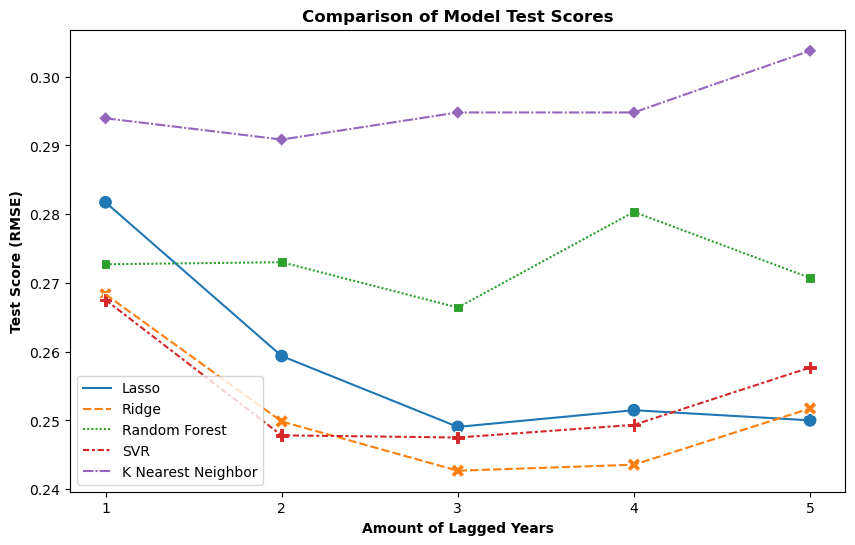

In [66]:
# create dataframe with all model results 
final_results = pd.DataFrame(score_dict)
inde = pd.Series([1,2,3,4,5])
final_results.set_index(inde,inplace=True)

# create plots for results 
fig, ax = plt.subplots(figsize=(10, 6))
lineplot = sns.lineplot(final_results)
scatterplot = sns.scatterplot(final_results,s=100,legend=False)

lineplot.set_xticks([1,2,3,4,5])

# lable plot
plt.title('Comparison of Model Test Scores',weight='bold')
plt.xlabel('Amount of Lagged Years',weight='bold')
plt.ylabel('Test Score (RMSE)',weight='bold')

# save plot to folder
plt.savefig(fname='../figures/model_testscore_comparison',format='png',dpi=300)

plt.show()